# **Multinomial Naive Bayes**

In [ ]:
import os
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score


# 1. Chuẩn bị dữ liệu
def load_data(data_path):
    data = []
    labels = []
    for topic in os.listdir(data_path):
        topic_path = os.path.join(data_path, topic)
        if os.path.isdir(topic_path):
            for filename in os.listdir(topic_path):
                file_path = os.path.join(topic_path, filename)
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
                    data.append(text)
                    labels.append(topic)
    return data, labels


def build_vocabulary(data):
    vocab = set()  # Tạo một tập hợp rỗng để lưu các từ
    for text in data:
        words = text.split()  # Tách các từ bằng dấu cách
        vocab.update(words)  # Thêm các từ vào tập hợp từ vựng
    return list(vocab)  # Trả về danh sách từ vựng duy nhất

def create_bag_of_words(data, vocab_index):
    bag_of_words = np.zeros((len(data), len(vocab_index)), dtype=int)

    for i, text in enumerate(data):
        words = text.split()
        for word in words:
            if word in vocab_index:
                bag_of_words[i][vocab_index[word]] += 1
    return bag_of_words

# 3. Tính toán xác suất tiên nghiệm P(C_k)
def calculate_prior_probabilities(labels):

    # Đếm số lần xuất hiện của từng nhãn
    label_uni, count = np.unique(labels, return_counts=True)

    # Tính tổng số văn bản
    total_docs = len(labels)

    priors = count / total_docs
    return label_uni, np.array(priors)


# 4. Tính toán xác suất có điều kiện P(X_i|C_k)
def calculate_conditional_probabilities(bag_of_words, labels):
    label_uni, idx, count = np.unique(labels,return_index= True, return_counts=True)
    num_classes = len(label_uni)
    vocab_size = bag_of_words.shape[1]
    conditional_probs = np.zeros((num_classes, vocab_size), dtype=float)

    for i, label in enumerate(label_uni):
        # Lọc ra các tài liệu thuộc lớp hiện tại
        class_docs = bag_of_words[idx[i]:idx[i] + count[i],:]
        class_word_counts = np.sum(class_docs, axis=0)  # Tổng số từ trong tất cả các tài liệu của lớp hiện tại
        total_word_count = np.sum(class_word_counts)  # Tổng số từ trong lớp hiện tại

        # Tính xác suất có điều kiện với Laplace smoothing
        conditional_probs[i, :] = (class_word_counts + 1) / (total_word_count + vocab_size)

    return conditional_probs



def predict(text, priors, conditional_probs, vocab_index):
    words = text.split()  # Tách các từ bằng dấu cách
    log_priors = np.log(priors)  # Tính log của xác suất tiên nghiệm

    scores = np.zeros(len(priors), dtype=float)


    # Tạo mảng chỉ số tương ứng với các từ trong văn bản
    word_indices = [vocab_index[word] for word in words    if word in vocab_index]

    if word_indices:  # Kiểm tra nếu có từ nào trong văn bản khớp với từ vựng
        log_conditional_probs = np.log(conditional_probs[:, word_indices])
        scores = log_priors + np.sum(log_conditional_probs, axis=1)

    return np.argmax(scores), scores

def evaluate_model(test_data, test_labels, priors, conditional_probs, vocab_index, label_uni):
    predictions = []

    for text in test_data:
        predicted_label_idx, _ = predict(text, priors, conditional_probs, vocab_index)
        predictions.append(label_uni[predicted_label_idx])

    # Tính độ chính xác
    accuracy = accuracy_score(test_labels, predictions)

    return predictions, accuracy


In [ ]:

# Main program
data_path = 'data/data_train'  # Đường dẫn đến thư mục chứa dữ liệu
data, labels = load_data(data_path)

print(len(data))
print(len(labels))

5543
5543


In [ ]:
# Xây dựng từ điển từ các văn bản
vocab = build_vocabulary(data)
vocab_index = {word: i for i, word  in enumerate(vocab)}

bag_of_words = create_bag_of_words(data, vocab_index)

label_uni, priors = calculate_prior_probabilities(labels)



conditional_probs = calculate_conditional_probabilities(bag_of_words, labels)

print(bag_of_words.shape)
print(conditional_probs.shape)
print(label_uni)

(5543, 16562)
(10, 16562)
['batdongsan' 'chinhtri' 'doisong' 'dulich' 'giaitri' 'khoahoc'
 'kinhdoanh' 'phapluat' 'suckhoe' 'thethao']


In [ ]:
test_path = "data/data_test"
test_data, test_labels = load_data(test_path)

test_label_uni = np.unique(test_labels)
print(test_label_uni)
print(len(test_data))
print(len(test_labels))

['batdongsan' 'chinhtri' 'doisong' 'dulich' 'giaitri' 'khoahoc'
 'kinhdoanh' 'phapluat' 'suckhoe' 'thethao']
3374
3374


In [ ]:
predictions, accuracy = evaluate_model(test_data, test_labels, priors, conditional_probs, vocab_index, test_label_uni)

print(f"Độ chính xác của mô hình: {accuracy * 100:.2f}%")

Độ chính xác của mô hình: 86.01%


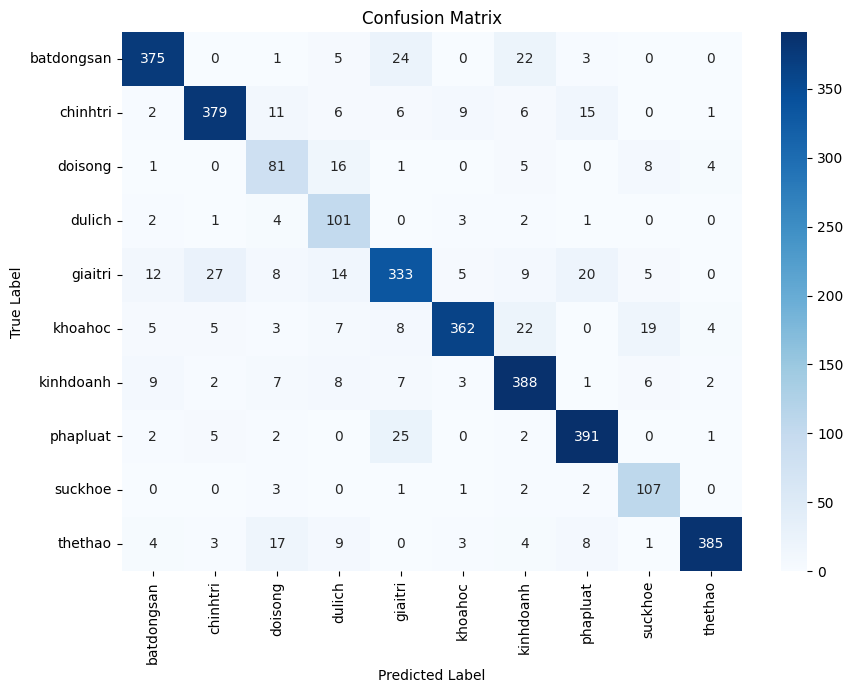

In [ ]:
cm = confusion_matrix(test_labels, predictions, labels=test_label_uni)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_label_uni, yticklabels=test_label_uni)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

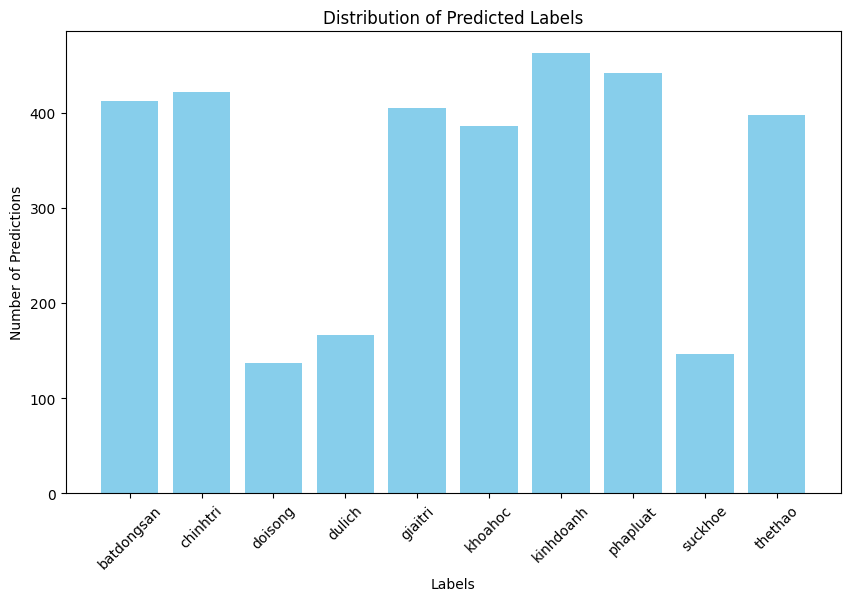

In [ ]:
def plot_predictions_distribution(predictions, labels):
    unique_labels, counts = np.unique(predictions, return_counts=True)
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color='skyblue')
    plt.xlabel("Labels")
    plt.ylabel("Number of Predictions")
    plt.title("Distribution of Predicted Labels")
    plt.xticks(rotation=45)
    plt.show()

# Gọi hàm để vẽ biểu đồ phân bố dự đoán
plot_predictions_distribution(predictions, np.unique(labels))

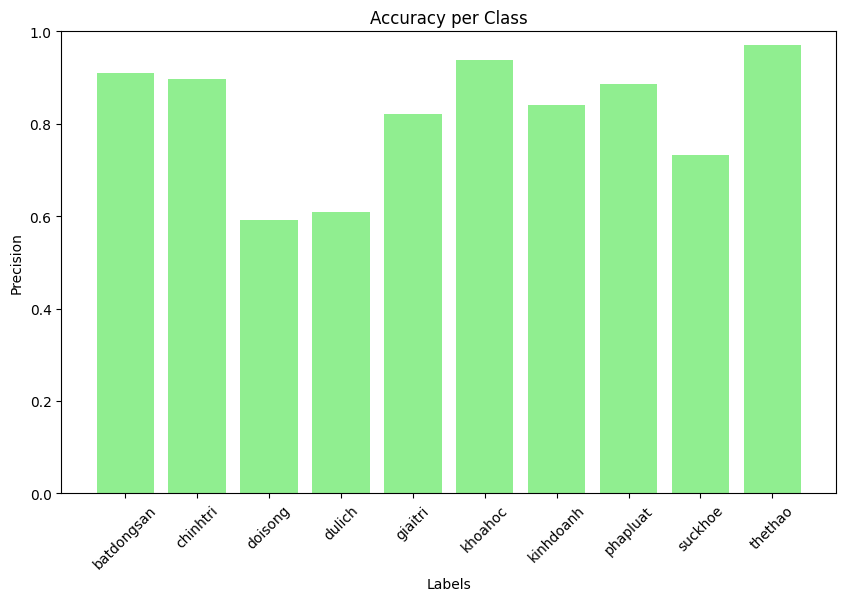

In [ ]:
from sklearn.metrics import classification_report

def plot_accuracy_per_class(test_labels, predictions, labels):
    report = classification_report(test_labels, predictions, target_names=labels, output_dict=True)
    accuracy_per_class = [report[label]['precision'] for label in labels]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, accuracy_per_class, color='lightgreen')
    plt.xlabel("Labels")
    plt.ylabel("Precision")
    plt.title("Accuracy per Class")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.show()

# Gọi hàm để vẽ biểu đồ độ chính xác trên từng lớp
plot_accuracy_per_class(test_labels, predictions, np.unique(labels))


# **KNN**

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

def euclidean_distance(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2) ** 2))


def knn_predict(X_train, y_train, X_test, k=3):
    predictions = []

    for test_vector in X_test:
        distances = []

        # Tính khoảng cách từ vector kiểm tra đến tất cả các vector huấn luyện
        for i in range(len(X_train)):
            distance = euclidean_distance(X_train[i], test_vector)
            distances.append((distance, y_train[i]))

        # Sắp xếp danh sách khoảng cách
        distances.sort(key=lambda x: x[0])

        # Lấy k hàng xóm gần nhất
        k_nearest_neighbors = distances[:k]

        # Lấy nhãn của các hàng xóm
        k_nearest_labels = [label for _, label in k_nearest_neighbors]

        # Đếm tần suất nhãn xuất hiện và chọn nhãn có tần suất cao nhất bằng numpy
        labels, counts = np.unique(k_nearest_labels, return_counts=True)
        most_common_label = labels[np.argmax(counts)]
        predictions.append(most_common_label)

    return np.array(predictions)



In [ ]:
print(bag_of_words.shape)
print(len(labels))
print(len(test_data))
print(len(test_labels))

(5543, 16562)
5543
3374
3374


In [ ]:
X_train = bag_of_words.copy()
y_train = np.array(labels.copy())

X_test = create_bag_of_words(test_data, vocab_index)
y_test = np.array(test_labels.copy())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(5543, 16562) (5543,)
(3374, 16562) (3374,)


In [ ]:
pca = PCA(n_components=100)  # Giảm xuống 100 đặc trưng
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape, X_test_pca.shape)

(5543, 100) (3374, 100)


In [ ]:
K = 3
y_pred = knn_predict(X_train_pca, y_train, X_test_pca, K)

# Tính toán độ chính xác
acc = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 77.68%


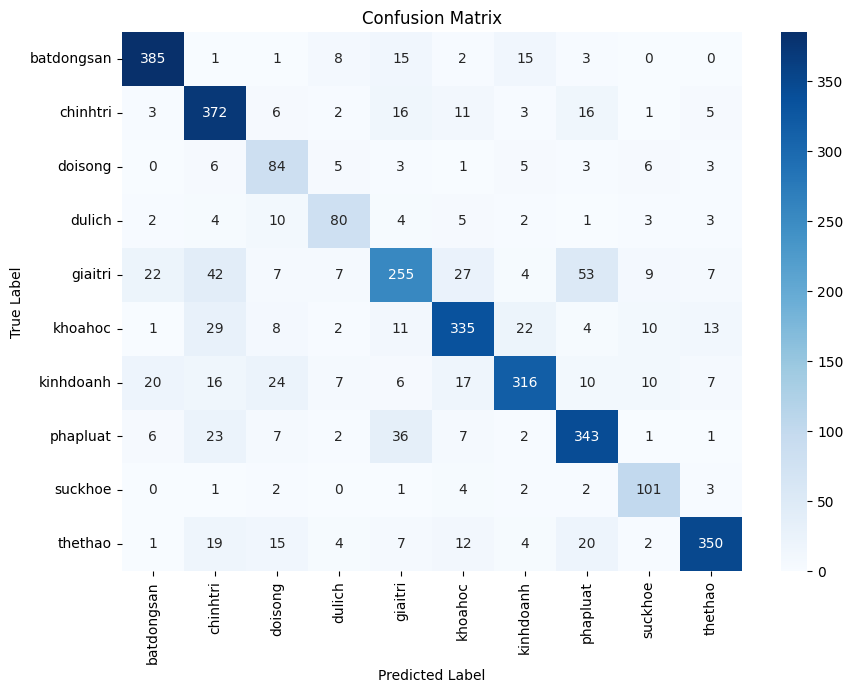

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=test_label_uni)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_label_uni, yticklabels=test_label_uni)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

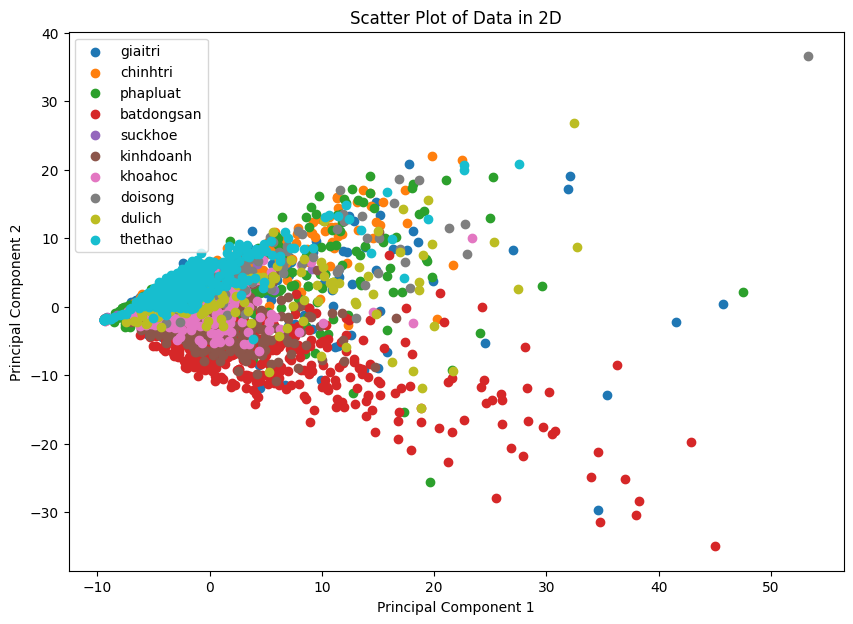

In [ ]:
def plot_scatter(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 7))
    for label in set(y):
        indices = [i for i, l in enumerate(y) if l == label]
        plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=label)

    plt.title('Scatter Plot of Data in 2D')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best')
    plt.show()

plot_scatter(X_test_pca, y_test)


n_components: 10, Accuracy: 68.64%
n_components: 20, Accuracy: 75.82%
n_components: 50, Accuracy: 78.69%
n_components: 100, Accuracy: 77.15%
n_components: 150, Accuracy: 75.79%
n_components: 200, Accuracy: 74.78%
n_components: 300, Accuracy: 72.67%
n_components: 400, Accuracy: 70.33%
n_components: 500, Accuracy: 68.91%


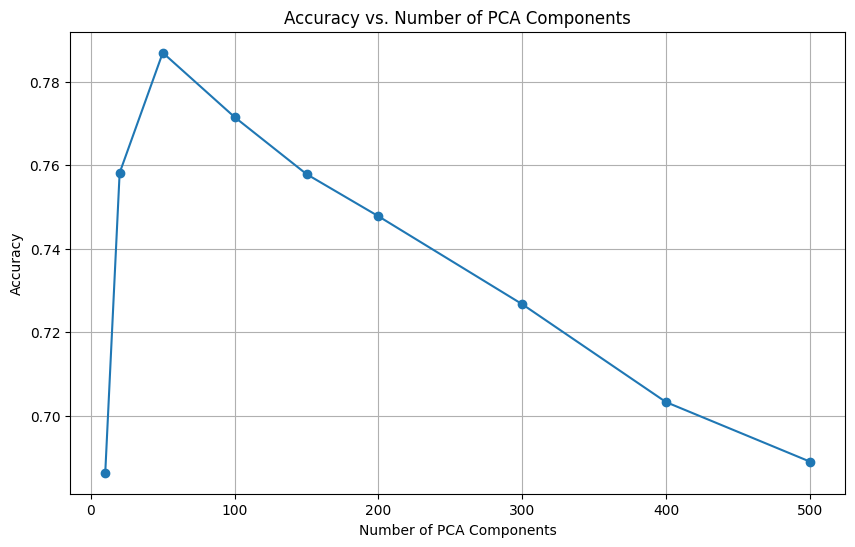

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Tạo danh sách các giá trị n_components cần thử
n_components_list = [10, 20, 50, 100, 150, 200, 300, 400, 500]
accuracies = []

for n_components in n_components_list:
    # Áp dụng PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Dự đoán nhãn với KNN
    y_pred = knn_predict(X_train_pca, y_train, X_test_pca, k=3)

    # Tính toán độ chính xác
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f'n_components: {n_components}, Accuracy: {acc * 100:.2f}%')

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, accuracies, marker='o')
plt.title('Accuracy vs. Number of PCA Components')
plt.xlabel('Number of PCA Components')
]
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
